In [1]:
from __future__ import annotations
import numpy as np
from scipy.linalg import block_diag
from matplotlib import pyplot as plt
from impl import SIModel

In [2]:
#if you want to save figures, set this to True
VISUALIZE = False

def create_erdos_graph_matrix(size: int, prob_of_connection: float)->SIModel:
    m = np.zeros((size, size))
    m = np.matrix(m)

    for i in range(size):
        for j in range(size):
            m[i,j] = np.random.random()*prob_of_connection
    return m

def create_correlation_matrix(N: int)->np.matrix:
    prob_10 = 0.1
    prob_100 = 0.01
    prob_1000 = 0.001
    m = np.matrix([[prob_1000 for i in range(N)] for i in range(N)])
    block_100 = np.matrix([[prob_100 for i in range(N//10)] for i in range(N//10)])
    m_100 = block_diag(*([block_100] * (N//100)))
    for i in range(N):
        for j in range(N):
            if(m_100[i,j] > 0):
                m[i,j] = prob_100
    
    block_10 = np.matrix([[prob_10 for i in range(N//100)] for i in range(N//100)])
    m_10 = block_diag(*([block_10] * (N//10)))
    for i in range(N):
        for j in range(N):
            if(m_10[i,j] > 0):
                m[i,j] = prob_10
    return m

def create_simple_correlation_matrix(N: int)->np.matrix:
    prob_max = 0.01
    m = np.matrix([[prob_max - np.sqrt(np.abs(i-j))/N**2 for i in range(N)] for j in range(N)])
    return m

<Figure size 640x480 with 0 Axes>

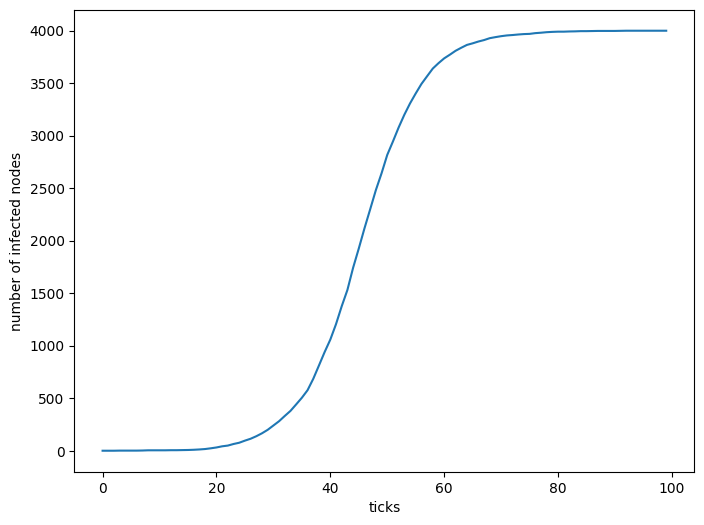

number of nodes:  4000
number of edges:  39976


In [3]:
#create an erdos graph
corr_mat = create_erdos_graph_matrix(4000, 0.01)
if VISUALIZE:
    plt.savefig('out/matrix_erdos.jpg', dpi=300)
g = SIModel.from_correlation_matrix(corr_mat, 0.01)

#infect node 0
g.nodes[0].infected = True

#gather data
tick_numbers = []
infected_at_tick = []

#watch chaos unfold
for i in range(100):
    g.tick()
    tick_numbers.append(i)
    infected_at_tick.append(g.amount_of_infected)    

#plot the sucker
plt.figure(figsize = (8,6))
plt.plot(tick_numbers, infected_at_tick)
plt.xlabel('ticks')
plt.ylabel('number of infected nodes')

if VISUALIZE:
    plt.savefig('out/graph_erdos.jpg', dpi=300)
plt.show()

print("number of nodes: ", len(g.nodes))
print("number of edges: ", g.number_of_edges)

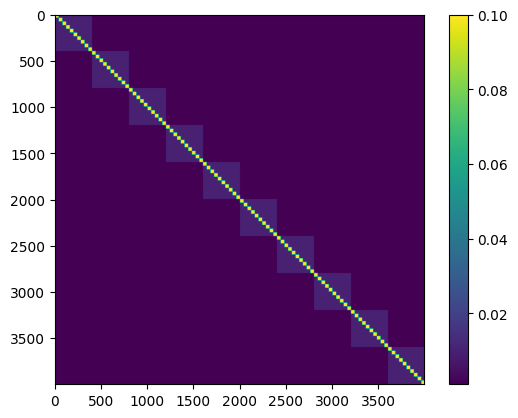

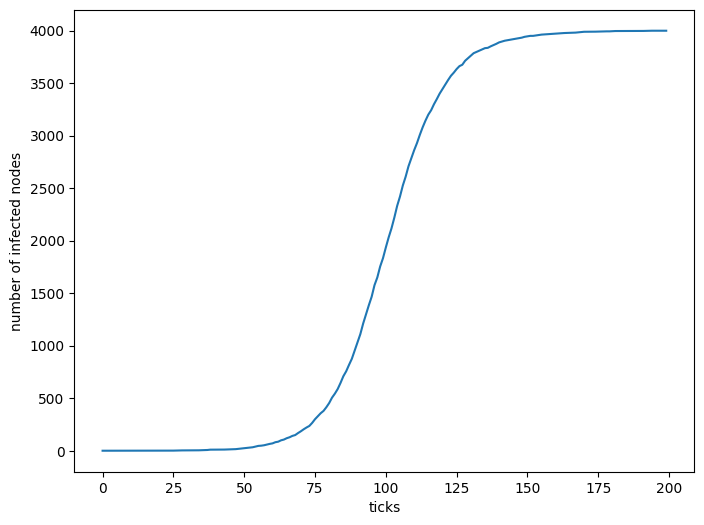

number of nodes:  4000
number of edges:  22332


In [4]:
#create correlation matrix
corr_mat = create_correlation_matrix(4000)

#plot it to see what it looks like
plt.imshow(corr_mat)
plt.colorbar()

if VISUALIZE:
    plt.savefig('out/matrix_layered.jpg', dpi=300)

plt.show()

#create correlation (probability) matrix
corr_mat = create_correlation_matrix(4000)

#create a model from the matrix
g = SIModel.from_correlation_matrix(corr_mat, 0.01)

#set first node to infected
g.nodes[0].infected = True

#gather data
tick_numbers = []
infected_at_tick = []

#watch chaos unfold
for i in range(200):
    g.tick()
    tick_numbers.append(i)
    infected_at_tick.append(g.amount_of_infected)    

#plot the sucker
plt.figure(figsize = (8,6))
plt.plot(tick_numbers, infected_at_tick)
plt.xlabel('ticks')
plt.ylabel('number of infected nodes')

if VISUALIZE:
    plt.savefig('out/graph_layered.jpg', dpi=300)

plt.show()

print("number of nodes: ", len(g.nodes))
print("number of edges: ", g.number_of_edges)

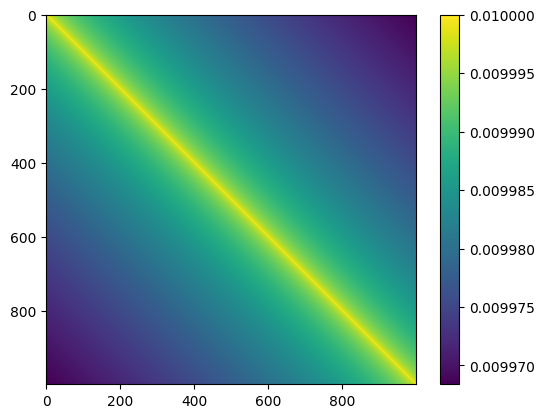

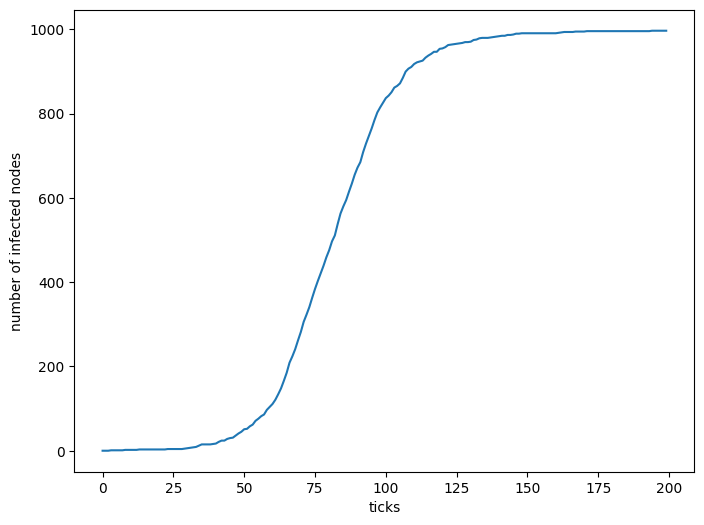

number of nodes:  1000
number of edges:  4919


In [5]:
corr_mat = create_simple_correlation_matrix(1000)
plt.imshow(corr_mat)
plt.colorbar()

if VISUALIZE:
    plt.savefig('out/matrix_smooth.jpg', dpi=300)

plt.show()

#create a model from the matrix
g = SIModel.from_correlation_matrix(corr_mat, 0.01)

#set first node to infected
g.nodes[0].infected = True

#gather data
tick_numbers = []
infected_at_tick = []

#watch chaos unfold
for i in range(200):
    g.tick()
    tick_numbers.append(i)
    infected_at_tick.append(g.amount_of_infected)    

#plot the sucker
plt.figure(figsize = (8,6))
plt.plot(tick_numbers, infected_at_tick)
plt.xlabel('ticks')
plt.ylabel('number of infected nodes')

if VISUALIZE:
    plt.savefig('out/graph_smooth.jpg', dpi=300)

plt.show()

print("number of nodes: ", len(g.nodes))
print("number of edges: ", g.number_of_edges)

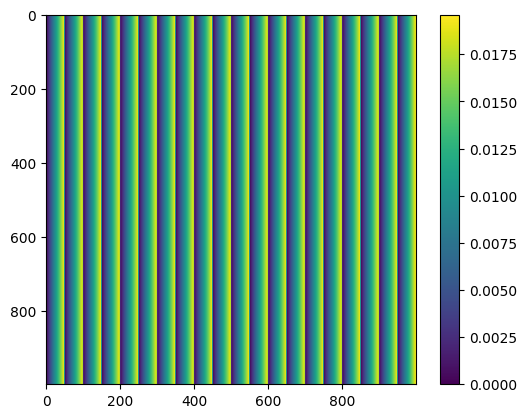

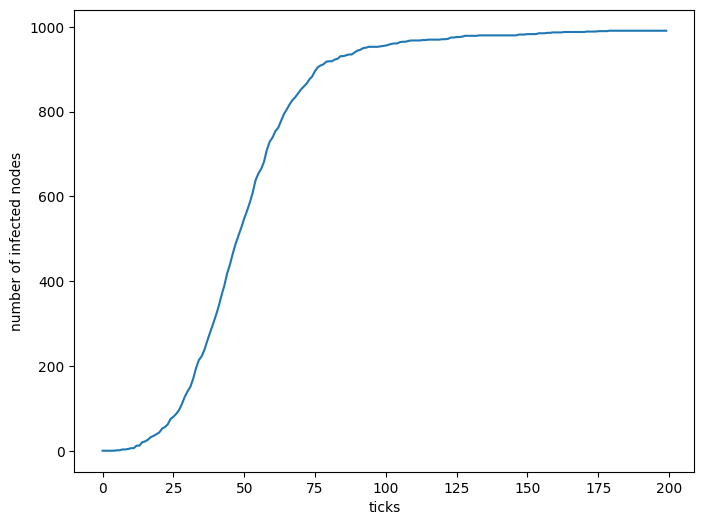

number of nodes:  1000
number of edges:  5011


In [14]:

def create_periodic_correlation_matrix(N: int, prob_max)->np.matrix:
    m = np.matrix([[(i % 50)/50*(prob_max - np.sqrt(np.abs(i-j))/N**2)  for i in range(N)] for j in range(N)])
    return m

corr_mat = create_periodic_correlation_matrix(1000, 0.02)
plt.imshow(corr_mat)
plt.colorbar()

if VISUALIZE:
    plt.savefig('out/matrix_striped.jpg', dpi=300)

#create a model from the matrix
g = SIModel.from_correlation_matrix(corr_mat, 0.01)

#set first node to infected
g.nodes[0].infected = True

#gather data
tick_numbers = []
infected_at_tick = []

#watch chaos unfold
for i in range(200):
    g.tick()
    tick_numbers.append(i)
    infected_at_tick.append(g.amount_of_infected)    

#plot the sucker
plt.figure(figsize = (8,6))
plt.plot(tick_numbers, infected_at_tick)
plt.xlabel('ticks')
plt.ylabel('number of infected nodes')


if VISUALIZE:
    plt.savefig('out/infected_per_tick_variable_correlation.jpg', dpi=300)

plt.show()

print("number of nodes: ", len(g.nodes))
print("number of edges: ", g.number_of_edges)

number of nodes:  1000
number of edges:  233


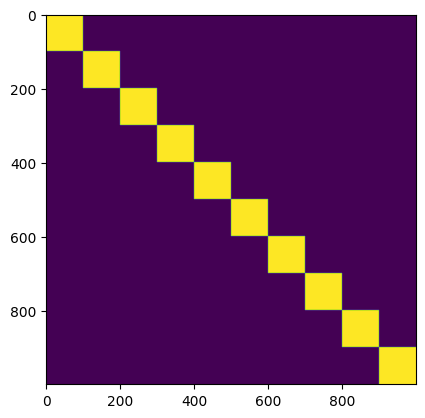

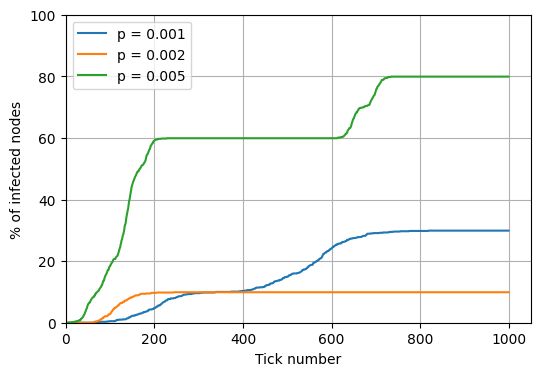

In [7]:
# Returns blocked out matrix
# N - rank of matrix
# block_count - list of numbers
# prob - probabilities of connection, same size as block_count
def create_blocked_matrix(N, block_count, prob):
    M = np.zeros((N, N))
    
    # We need to sort this so the rest of the code can word
    sort_order = np.argsort(block_count)
    block_count = np.array(block_count)[sort_order]
    prob = np.array(prob)[sort_order]


    n = len(block_count)
    for i in range(n):
        num_blocks = block_count[i]
        block_size = int(N / num_blocks)
        p = prob[i]
        for j in range(num_blocks):
            M[j*block_size:(j+1)*block_size, j*block_size:(j+1)*block_size].fill(p)

    return M

# Creates 100-by-100 matrix
# creates 5 block with probability 0.1
# creates 10 blocks with probability 0.5
num_nodes = 1000
div_count = [1, 10]
prob = [0.00002, 0.3]
M = create_blocked_matrix(num_nodes, div_count, prob)
plt.imshow(M)
if VISUALIZE:
    plt.savefig('out/matrix_block.jpg', dpi=300)


#Create models from one matrix, but diffrent probabilities of corruption
models = []
models.append(SIModel.from_correlation_matrix(M, 0.001))
models.append(SIModel.from_correlation_matrix(M, 0.002))
models.append(SIModel.from_correlation_matrix(M, 0.005))

num_models = len(models)

#set first node to infected
for m in models:
    m.nodes[0].infected = True


#gather data
tick_numbers = []
infected_at_tick = []
for i in range(num_models):
    infected_at_tick.append([])

#watch chaos unfold
for i in range(1000):
    tick_numbers.append(i)
    for j in range(num_models):
        models[j].tick()
        infected_at_tick[j].append(models[j].amount_of_infected)    

#plot the sucker
plt.figure(figsize = (6,4))
plt.plot(tick_numbers, np.array(infected_at_tick[0])/num_nodes*100, label='p = 0.001')
plt.plot(tick_numbers, np.array(infected_at_tick[1])/num_nodes*100, label='p = 0.002')
plt.plot(tick_numbers, np.array(infected_at_tick[2])/num_nodes*100, label='p = 0.005')
plt.legend()
plt.xlabel('Tick number')
plt.ylabel('% of infected nodes')

if VISUALIZE:
    plt.savefig('out/graph_block.jpg', dpi=300)
plt.xlim(left=0)
plt.ylim(bottom=0, top=100)
plt.grid()


print("number of nodes: ", len(g.nodes))
print("number of edges: ", g.number_of_edges)
if VISUALIZE:
    plt.savefig('schodki_4.pdf', bbox_inches='tight')
